# Python中的因子分析简介

https://www.datacamp.com/community/tutorials/introduction-factor-analysis

### 导入所需的库

In [1]:
# Import required libraries
import pandas as pd
from sklearn.datasets import load_iris
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

In [37]:
import pkg_resources

In [38]:
pkg_resources.get_distribution("factor_analyzer").version

'0.3.1'

## 加载数据

让我们对BFI（基于人格评估项目的数据集）进行因子分析，这是使用6点响应量表收集的：1非常不准确，2中度不准确，3略微不准确4准确，5中等准确，6非常准确。
您还可以从以下链接下载此数据集：https://vincentarelbundock.github.io/Rdatasets/datasets.html

In [15]:
df= pd.read_csv("yrd_ccn_new-all-pmcb1.csv")

### 预处理数据

# Dropping unnecessary columns
# NOTICE BJC is Time value
df.drop(['FAC1', 'FAC2', 'FAC3', 'FAC4', 'FAC5', 'FAC6', 'FAC7', 'FAC8'],axis=1,inplace=True)

In [16]:
df.drop(['CCN_1.0_cm3',"stid"],axis=1,inplace=True)

In [21]:
df.drop(['rain',"rain208","rain820"],axis=1,inplace=True)

In [17]:
df.shape

(796, 47)

In [18]:
# Dropping missing values rows
df.dropna(inplace=True)

In [19]:
df.shape

(779, 47)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 779 entries, 0 to 795
Data columns (total 47 columns):
CAPE_nc       779 non-null float64
CIN0          779 non-null float64
Cloud_fra     779 non-null float64
GH1000        779 non-null float64
GH500         779 non-null float64
GH700         779 non-null float64
GH850         779 non-null float64
H_LCL_nc      779 non-null float64
H_tro         779 non-null float64
Have          779 non-null float64
Hcbs1.0       779 non-null float64
Hsd           779 non-null float64
Htop1.0       779 non-null float64
LTS           779 non-null float64
PBLH          779 non-null float64
PR            779 non-null float64
PTEM700       779 non-null float64
PTEMS         779 non-null float64
PW            779 non-null float64
P_LCL_nc      779 non-null float64
P_tro         779 non-null float64
Pcb1.0        779 non-null float64
Press         779 non-null float64
Ptop1.0       779 non-null float64
RH2m          779 non-null float64
Recb1.0       779 no

In [22]:
df.head()

,CAPE_nc,CIN0,Cloud_fra,GH1000,GH500,GH700,GH850,H_LCL_nc,H_tro,Have,...,T_LCL_nc,T_coal1.0,T_tro,Tcb1.0,Tskin_NCEP,Ttop1.0,Wb_1.0,PM25,PM25cb,PM10
0,5.0,-0.61,0.5743,87.970001,5870.669922,3138.550049,1499.560059,1092.2,16511.0,211.0,...,16.9,19.0,-75.7,19.0,30.84,6.0,0.99,18.000000,5.941307,27.00
1,12.0,-0.01,0.7696,103.300003,5851.430176,3122.830078,1500.099976,981.0,16627.0,4.0,...,16.5,11.0,-74.2,13.0,25.86,-6.0,1.22,15.250000,2.269237,33.00
2,23.0,-0.71,0.5747,112.959999,5848.350098,3123.909912,1499.530029,212.5,16647.0,5.0,...,18.8,-14.0,-73.3,7.0,20.60,-24.0,1.28,21.875000,0.507255,39.25
3,0.0,-0.81,0.1157,117.489998,5841.910156,3121.350098,1501.020020,124.0,16669.0,26.0,...,18.7,-20.0,-73.4,-5.0,19.59,-43.0,2.32,11.250000,0.029086,30.00
4,0.0,-0.21,0.3095,113.699997,5846.069824,3123.209961,1498.010010,124.0,16669.0,42.0,...,18.7,-16.0,-73.4,3.0,19.48,-25.0,1.55,13.333333,0.125628,17.00


## 充分性测试
在执行因子分析之前，您需要评估数据集的“可用性”。Factorability意味着“我们能找到数据集中的因子吗？”。有两种方法可以检查可行性或抽样充分性：

* 巴特利特的考验
* Kaiser-Meyer-Olkin测试

**Bartlett**对球形度的检验使用观察到的相对矩阵对照单位矩阵检查观察到的变量是否完全相互关联。如果测试发现统计上不显着，则不应使用因子分析。

In [23]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df)
chi_square_value, p_value

(98148.374094729064, 0.0)

在该Bartlett检验中，p值为0.该检验具有统计学意义，表明观察到的相关矩阵不是单位矩阵。

**Kaiser-Meyer-Olkin（KMO）测试**测量数据在因子分析中的适用性。它确定了每个观测变量和完整模型的充分性。
KMO估计所有观测变量之间的方差比例。较低的比例id更适合因子分析。KMO值介于0和1之间.KMO小于0.6的值被认为是不合适的。

In [24]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df)

In [25]:
kmo_model

0.84395891656315969

我们数据的总体KMO为0.84，非常好。此值表示您可以继续进行计划的因子分析。

### 选择因素数量
要选择因子数，可以使用Kaiser标准和scree图。两者都基于特征值。

In [26]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation=None)
fa.fit(df)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([  1.34245620e+01,   6.02764774e+00,   4.72035062e+00,
         3.67524841e+00,   2.67000101e+00,   2.31756700e+00,
         1.87563353e+00,   1.30432264e+00,   1.08266969e+00,
         9.64145388e-01,   8.33479046e-01,   8.07275381e-01,
         7.46397907e-01,   5.54716295e-01,   4.73695223e-01,
         3.72950942e-01,   3.28420954e-01,   2.75711324e-01,
         2.39381677e-01,   2.09045063e-01,   2.04638642e-01,
         1.80461616e-01,   1.29445914e-01,   1.25207482e-01,
         8.72315887e-02,   8.39172503e-02,   7.98639777e-02,
         5.95055949e-02,   4.39160092e-02,   2.68973024e-02,
         2.20840920e-02,   1.82201720e-02,   1.32593426e-02,
         7.03993417e-03,   4.97682771e-03,   3.65006145e-03,
         3.58306436e-03,   1.42888193e-03,   9.08098251e-04,
         4.57921564e-04,   7.18799766e-05,   1.14393341e-05,
         9.93708894e-07,   9.18106639e-08])

在这里，您只能看到6个因子的特征值大于1。这意味着我们只需要选择6个因子（或未观察到的变量）。

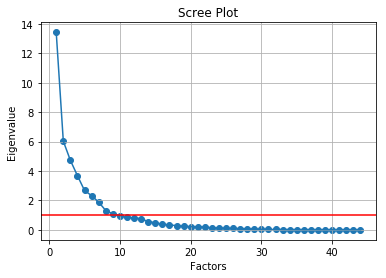

In [27]:
# Create scree plot using matplotlib
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='-')
plt.grid()
plt.show()

碎石图方法为每个因子及其特征值绘制一条直线。特征值大于1被认为是因子的数量。

在这里，您只能看到6个因子的特征值大于1。这意味着我们只需要选择6个因子（或未观察到的变量）。

## 执行因子分析

# Create factor analysis object and perform factor analysis

### for 0.2.3
fa = FactorAnalyzer()
fa.analyze(df, 6 ,rotation="varimax")

In [28]:
fav= FactorAnalyzer(n_factors=6,rotation="varimax")

In [29]:
fav.fit(df)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
        method='minres', n_factors=6, rotation='varimax',
        rotation_kwargs={}, use_smc=True)

In [30]:
fav.loadings_

array([[  2.61723459e-01,   7.70192957e-01,   1.77511485e-01,
          7.05390457e-02,  -8.94336956e-02,   1.65905246e-01],
       [  9.64835317e-02,   1.08001109e-01,  -3.18172623e-02,
         -2.58316865e-02,  -7.54830485e-02,   1.20968364e-02],
       [ -4.19077321e-01,  -1.49066385e-01,  -3.85000703e-02,
         -3.91952099e-01,   1.25589824e-01,  -4.39384026e-02],
       [ -1.48841272e-01,  -4.24515860e-01,  -3.77268540e-02,
          3.75959527e-03,  -3.52465743e-01,   8.17438669e-01],
       [  1.82794488e-01,   6.60443839e-01,   1.35098092e-01,
          2.09071488e-02,   3.53621919e-01,   5.82477745e-01],
       [  2.56129075e-01,   4.48980364e-01,   1.24590614e-01,
          6.69986132e-02,  -9.31220334e-02,   8.23376033e-01],
       [  2.06212500e-01,   4.71808679e-02,   7.05991301e-02,
          6.72521971e-02,  -3.21683078e-01,   8.92946467e-01],
       [  8.87957848e-01,  -6.58577371e-03,   1.45115665e-01,
          2.39683818e-01,   7.10685634e-03,   5.14436510e-02],


* 因子1具有E1，E2，E3，E4和E5（外向）的高因子负载

* 因子2对N1，N2，N3，N4和N5具有高因子负荷（神经质）

* 因子3具有C1，C2，C3，C4和C5的高因子负载（尽责）

* 因子4对O1，O2，O3，O4和O5具有高因子负载（Opennness）

* 因子5具有A1，A2，A3，A4和A5的高因子载荷（令人满意）

* 因子6没有任何变量的高值，并且不易解释。如果我们只采取五个因素，这是好的。

让我们对5个因素进行因子分析。

In [31]:
#Calculate the eigenvalues, given the factor correlation matrix
fav.get_eigenvalues()

(array([  1.34245620e+01,   6.02764774e+00,   4.72035062e+00,
          3.67524841e+00,   2.67000101e+00,   2.31756700e+00,
          1.87563353e+00,   1.30432264e+00,   1.08266969e+00,
          9.64145388e-01,   8.33479046e-01,   8.07275381e-01,
          7.46397907e-01,   5.54716295e-01,   4.73695223e-01,
          3.72950942e-01,   3.28420954e-01,   2.75711324e-01,
          2.39381677e-01,   2.09045063e-01,   2.04638642e-01,
          1.80461616e-01,   1.29445914e-01,   1.25207482e-01,
          8.72315887e-02,   8.39172503e-02,   7.98639777e-02,
          5.95055949e-02,   4.39160092e-02,   2.68973024e-02,
          2.20840920e-02,   1.82201720e-02,   1.32593426e-02,
          7.03993417e-03,   4.97682771e-03,   3.65006145e-03,
          3.58306436e-03,   1.42888193e-03,   9.08098251e-04,
          4.57921564e-04,   7.18799766e-05,   1.14393341e-05,
          9.93708894e-07,   9.18106639e-08]),
 array([  1.32753350e+01,   5.82334616e+00,   4.54443724e+00,
          3.45642898e+00

In [32]:
# Calculate the communalities, given the factor loading matrix.
fav.get_communalities()

array([ 0.73370538,  0.02849695,  0.37065868,  0.99624297,  0.95261728,
        0.97381691,  0.95509012,  0.86971636,  0.62203573,  0.26889215,
        0.97511072,  0.29644761,  0.86605191,  0.86083378,  0.77884529,
        0.32085272,  0.84985149,  0.98601903,  0.61913214,  0.92556176,
        0.55899649,  0.97690638,  0.26953324,  0.93895717,  0.86791138,
        0.3804653 ,  0.71583503,  0.78677934,  0.78330783,  0.98514638,
        0.95516134,  0.67528563,  0.84985353,  0.86385818,  0.86406057,
        0.78886594,  0.76476689,  0.99141197,  0.85490575,  0.91921526,
        0.97504564,  0.13706157,  0.38967796,  0.03096074])

In [33]:
# Get variance of each factors
fav.get_factor_variance()

(array([ 7.57480591,  6.83537053,  6.31567373,  4.10643438,  3.97398482,
         2.76767912]),
 array([ 0.17215468,  0.15534933,  0.14353804,  0.09332805,  0.09031784,
         0.0629018 ]),
 array([ 0.17215468,  0.32750401,  0.47104205,  0.5643701 ,  0.65468794,
         0.71758974]))

In [34]:
#Calculate the uniquenesses, given the factor loading matrix.
fav.get_uniquenesses()

array([ 0.26629462,  0.97150305,  0.62934132,  0.00375703,  0.04738272,
        0.02618309,  0.04490988,  0.13028364,  0.37796427,  0.73110785,
        0.02488928,  0.70355239,  0.13394809,  0.13916622,  0.22115471,
        0.67914728,  0.15014851,  0.01398097,  0.38086786,  0.07443824,
        0.44100351,  0.02309362,  0.73046676,  0.06104283,  0.13208862,
        0.6195347 ,  0.28416497,  0.21322066,  0.21669217,  0.01485362,
        0.04483866,  0.32471437,  0.15014647,  0.13614182,  0.13593943,
        0.21113406,  0.23523311,  0.00858803,  0.14509425,  0.08078474,
        0.02495436,  0.86293843,  0.61032204,  0.96903926])

In [35]:
#Get the factor scores for new data set.
fav.transform(df)

array([[  8.10027569e+00,   4.84849707e+00,  -1.18193151e+00,
         -9.75992004e-01,   2.10159041e-01,  -1.81256985e+00],
       [  9.76364192e+00,   4.23769125e+00,  -1.98970032e+00,
         -2.03741594e+00,   5.81570922e-01,  -2.35055927e+00],
       [ -9.70559205e+01,  -9.43860797e+01,   2.13321751e+01,
          9.75395782e+00,   1.34497097e+01,   4.88035158e+01],
       ..., 
       [  9.83146859e+00,   8.52243323e+00,  -2.11974830e+00,
         -1.05603993e-02,  -4.14913285e+00,  -3.72626293e+00],
       [ -4.13741114e+00,  -3.02275483e+00,  -4.16779219e-02,
          8.87173908e-01,   7.42539618e-01,   8.10742947e-01],
       [  2.11867545e+00,   4.90141647e+00,  -2.31212387e+00,
          1.55473218e+00,  -1.43802620e+00,  -2.62859929e+00]])

In [36]:
fav.transform(df).shape

(779, 6)

## 因子分析的利弊

因子分析探索大型数据集并找到相互关联的关联。它将观察到的变量减少为几个未观察到的变量或识别相互关联的变量组，这有助于市场研究人员压缩市场情况并找出消费者品味，偏好和文化影响之间的隐藏关系。此外，它有助于改进未来调查的调查问卷。因素可以提供更自然的数据解释。

因子分析的结果存在争议。它的解释是有争议的，因为可以对相同的数据因素进行不止一种解释。因子识别和因子命名需要领域知识。

## 结论


恭喜，您已经完成了本教程的结尾！

在本教程中，您已经了解了什么因素分析。不同类型的因子分析，因子分析如何工作，基本因子分析术语，选择因素数量，主成分分析和因子分析的比较，使用python FactorAnalyzer包在python中实现，以及因子分析的优缺点。

我期待听到任何反馈或问题。您可以通过发表评论来提出问题，我会尽力回答。

如果您想了解有关Python中的因素的更多信息，请参阅DataCamp 在Python中的无监督学习课程。

# issue
同样的问题。解决了安装先前版本的因子分析器的问题：

pip install factor_analyzer == 0.2.3

非常感谢Avinash教程。

by liuchongcn@126.com @NJU 2019-07-03

![简书](https://raw.githubusercontent.com/xigrug/xigrug.github.io/master/picture/jianshuQR1.jpg)